In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as Data

In [2]:
import yfinance as yf

In [3]:
data = pd.read_csv("NVDA.csv")
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-05-28,21.22,21.58,21.18,21.51,8191400,0.0,0
1,2015-05-29,21.51,21.65,21.47,21.50,8379200,0.0,0
2,2015-06-01,21.64,21.96,21.50,21.75,9316500,0.0,0
3,2015-06-02,21.61,21.73,21.30,21.32,5607600,0.0,0
4,2015-06-03,21.38,21.54,21.05,21.09,6269700,0.0,0
...,...,...,...,...,...,...,...,...
1254,2020-05-20,359.64,361.72,355.55,358.80,14688400,0.0,0
1255,2020-05-21,362.06,362.10,349.50,351.01,19026700,0.0,0
1256,2020-05-22,353.01,363.72,348.53,361.05,25969100,0.0,0
1257,2020-05-26,366.27,367.27,346.88,348.71,19269500,0.0,0


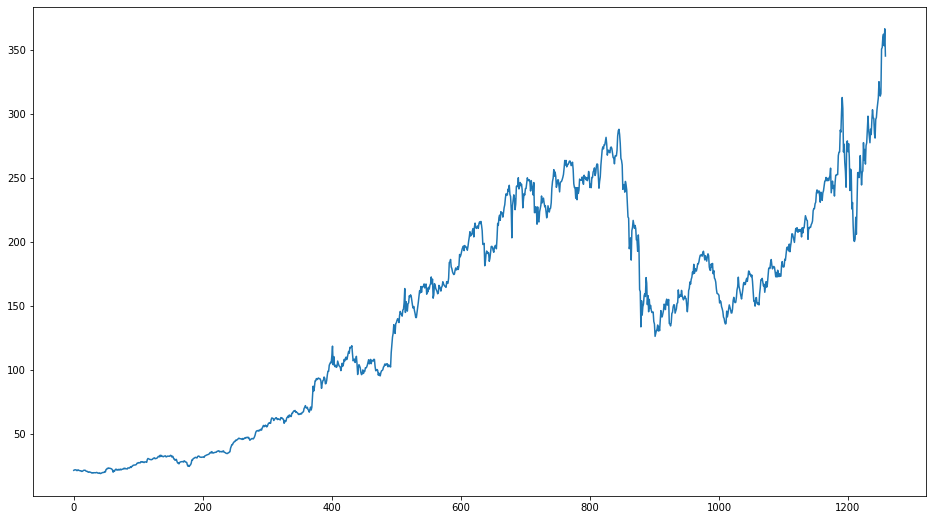

In [4]:
data['Open'].plot(figsize=(16, 9))

In [5]:
dataset_train = data
training_set = dataset_train.iloc[:, 1:2].values

In [6]:
len(training_set)

1259

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
X_train = []
y_train = []
for i in range(60, len(training_set)-200):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [9]:
X_train.shape

torch.Size([999, 60])

In [10]:
y_train = y_train.reshape(1, len(X_train), -1)

In [11]:
y_train.shape

torch.Size([1, 999, 1])

In [12]:
X_train = X_train.reshape(1, len(X_train), 60)

In [13]:
X_train.shape

torch.Size([1, 999, 60])

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=4, dropout=0.1)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, inputs):
        output, hidden = self.lstm(inputs)
        out = self.linear(output)
        return(out)

In [15]:
model = LSTM(60, 70)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
print(model)

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.1)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)


In [17]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.zero_grad()
    y_pred = model(X_train)
    loss= loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print("Epoch: ", epoch+1, "| Loss: ", float(loss))

Epoch:  1 | Loss:  0.1287308633327484
Epoch:  11 | Loss:  0.09221161156892776
Epoch:  21 | Loss:  0.04417209327220917
Epoch:  31 | Loss:  0.031155044212937355
Epoch:  41 | Loss:  0.02128908783197403
Epoch:  51 | Loss:  0.014162207953631878
Epoch:  61 | Loss:  0.009357592090964317
Epoch:  71 | Loss:  0.006689202971756458
Epoch:  81 | Loss:  0.005560555960983038
Epoch:  91 | Loss:  0.004643918015062809
Epoch:  101 | Loss:  0.0041538430377841
Epoch:  111 | Loss:  0.0037123183719813824
Epoch:  121 | Loss:  0.003305045422166586
Epoch:  131 | Loss:  0.0027558444999158382
Epoch:  141 | Loss:  0.00226081651635468
Epoch:  151 | Loss:  0.0019915266893804073
Epoch:  161 | Loss:  0.001603265991434455
Epoch:  171 | Loss:  0.0017077818047255278
Epoch:  181 | Loss:  0.001559047494083643
Epoch:  191 | Loss:  0.001368089229799807
Epoch:  201 | Loss:  0.0013778606662526727
Epoch:  211 | Loss:  0.0013424111530184746
Epoch:  221 | Loss:  0.0012420210987329483
Epoch:  231 | Loss:  0.001245049643330276
Epoc

## Test

In [18]:
# Getting the stock price of 2020
dataset_test = pd.read_csv("NVDA.csv")
dataset_test = dataset_test.iloc[-200:]
len(dataset_test)

200

In [19]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [20]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = torch.Tensor(X_test)
X_test = X_test.reshape(1, len(X_test), 60)
predicted_stock_price = model(X_test)
predicted_stock_price = torch.Tensor.cpu(predicted_stock_price).detach().numpy()[-1]
predicted_stock_price = sc.inverse_transform(np.array(predicted_stock_price))

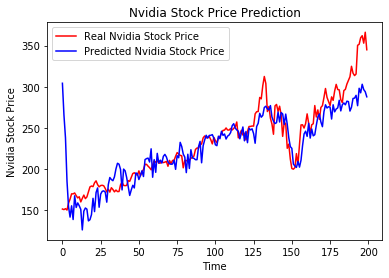

In [21]:
plt.plot(real_stock_price, color = 'red', label = 'Real Nvidia Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')
plt.legend()
plt.show()